In [1]:
import pandas as pd
import numpy as np
from pygobnilp.gobnilp import Gobnilp
import pgmpy
import itertools
from pgmpy.estimators.CITests import pearsonr
from pgmpy.estimators.CITests import chi_square
import networkx as nx
import time
import collections

In [2]:
def csv_format_discrete(csv_file):
    df = pd.read_csv(csv_file, sep="\s+")
    return df.drop([0])

#returns the csv_file in a pandas dataframe, formatted properly, discrete dataset only

In [12]:
#small network : n <= 20 nodes, medium network: 20 <= n <= 50 , large: 50 <= n <= 100, ... 
df_small = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\asia_10000.dat")
df_medium = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_10000.dat")
df_alarm100 = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_100.dat")
df_large = pd.read_csv(r'FORMED_final_0.csv')
df_large = df_large.drop([0])
# df_large = csv_format_discrete(r"")

In [13]:
df_large

,PCLRfacet3,AbilityToCope,Stress,ProblematicLifeEvents,Victimisation,ViolentThoughts,Impulsivity,BPD,AbuseNeglectAsChild,PCLRfactor2,...,Hallucinations,HallucinationsPT,StrangeExperiences,StrangeExperiencesPT,ParanoidDelusions,ParanoidDelusionsPT,PsychiatricTreatment,PsychiatricTreatmentGivenRFAT,MentalIllnessSymptomCount,MentalIllnessDL
1,0,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
2,0,1,1,0,0,0,1,0,0,2,...,1,1,0,0,0,0,0,0,1,1
3,0,1,0,0,0,0,1,0,0,2,...,0,0,0,0,1,1,0,0,2,1
4,0,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,1,0,0,2,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,1,1,0,0,1,0,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0
99997,0,1,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
99998,1,0,0,0,0,0,1,1,1,1,...,1,1,0,0,0,0,0,0,1,0
99999,2,1,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### chi2 test 0th order

In [14]:
#0th order chi2 test
def chi2bool(df, rho):
    '''
    0th order CI test
    
    Parameters:
    df -> pandas dataframe
    rho -> significance level, only accept 0 <= rho <= 1.0
    '''
    chi2 = []
    v = list(df)
    my_list = list(itertools.combinations(v,2))
    y_0, y_1 = [x[0] for x in my_list], [x[1] for x in my_list]
    for i,j in zip(y_0, y_1):
        chi = chi_square(X=i, Y=j, Z=[], data=df, significance_level=rho)
        chi2.append((i,j,chi))
    true_0 = [x for x in chi2 if True in x]
    false_0 = [x for x in chi2 if False in x]
    return true_0, false_0

### ### Pearson's Product Moment Correlation Coefficient

In [15]:
df_gaus = pd.read_csv(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\gaussian.dat", sep="\s+")
df_gaus

,A,B,C,D,E,F,G
0,1.113083,1.932164,7.074806,8.660411,0.881591,24.719501,9.216382
1,-0.247948,11.334343,24.347372,23.355432,7.040113,36.812996,3.678833
2,1.854508,3.032020,11.086473,11.055891,3.834530,22.017182,2.424513
3,0.833911,3.857970,11.224775,11.937471,1.005624,23.285643,6.085473
4,0.488614,4.512613,10.000476,12.537179,4.084746,24.537596,5.117575
...,...,...,...,...,...,...,...
4995,0.625860,1.587941,5.952431,8.516822,4.894385,16.950123,2.558535
4996,0.241723,-0.497071,1.695681,5.563204,7.454081,21.165266,4.867241
4997,2.527720,-2.706339,0.984988,1.597447,3.692427,18.808892,5.598200
4998,1.484585,1.468603,7.206672,8.486116,2.611856,21.528922,5.106188


In [16]:
#0th order chi2 test
def PMCC(df, rho):
    '''
    0th order CI test
    
    Parameters:
    df -> pandas dataframe
    rho -> significance level, only accept 0 <= rho <= 1.0
    '''
    R_list = []
    v = list(df)
    my_list = list(itertools.combinations(v,2))
    y_0, y_1 = [x[0] for x in my_list], [x[1] for x in my_list]
    for i,j in zip(y_0, y_1):
        R = pearsonr(X=i, Y=j, Z=[], data=df, significance_level=rho)
        R_list.append((i,j,R))
    true_0 = [x for x in R_list if True in x]
    false_0 = [x for x in R_list if False in x]
    return true_0, false_0

### Constraint-based algorithm

In [17]:
def Graph(df):
    G = nx.Graph()
    v = list(df)
    for i in v:
        G.add_node(i)
    k = list(itertools.combinations(v,2))
    for i,j in k:
        G.add_edge(i,j)
#     print(G)
    return(G)

Graph with 88 nodes and 3828 edges


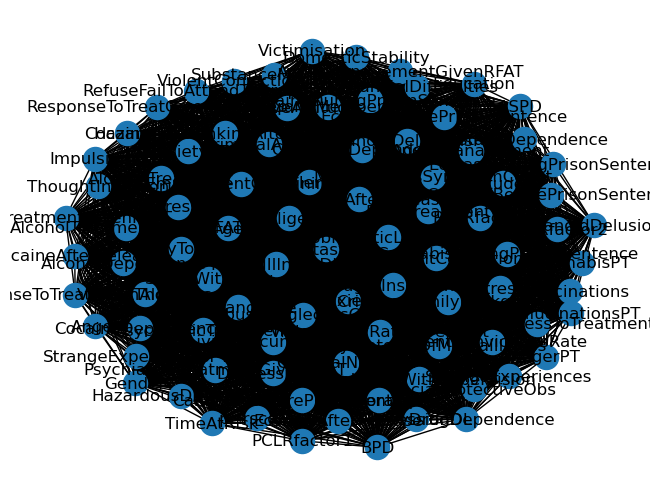

In [18]:
g = Graph(df_large)
print(g)
nx.draw(g, with_labels = True)

In [19]:
def PC_0(df, rho, G):
    '''
    finds 0th order conditional independencies (CI) between each node, if True then remove an edge 
    '''
    v = list(df)
    for i in v:
        G.add_node(i)
    k = list(itertools.combinations(v,2))
    for i,j in k:
        G.add_edge(i,j)
    ind_0 = [x[:2] for x in chi2bool(df, rho)[0]]
    for i,j in ind_0:
        G.remove_edge(i,j)
    print('the number of edges removed is:' , len(ind_0))
#     print(G)
    return(G, ind_0)

the number of edges removed is: 2687
Graph with 88 nodes and 1141 edges
CPU times: total: 15.5 s
Wall time: 15.6 s


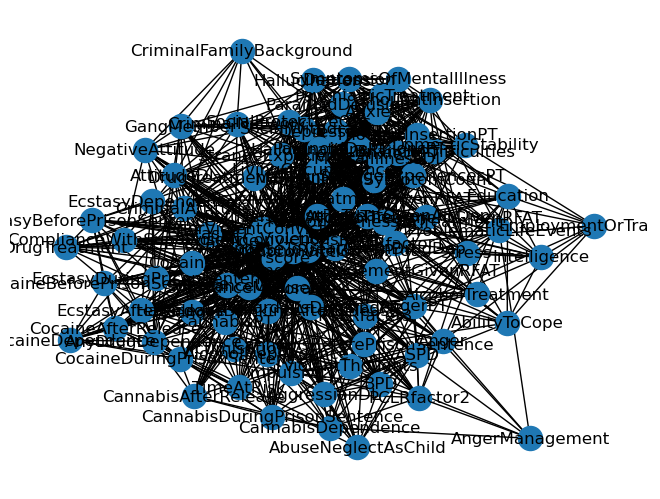

In [20]:
%%time
g_0 = PC_0(df_large, 0.05, g)[0]
print(g_0)
nx.draw(g_0, with_labels = True)

In [ ]:
def find_adjacency_XY(graph):    
    '''
    finds adjacencies of XY in the graph
    Input: a graph from networkx
    Returns: a list containing (X,Y, [XY_adjacents]) where X and Y are connected by an edge and XY_adjacents are its adjacents
    '''
    test_list = []
    graph_list = list(graph.edges)
    for i,j in graph_list:
        test_list.append((i, j, list(graph.edges(i)), list(graph.edges(j))))
    n = 0
    N = len(test_list)
    edge_XY = []
    while n < N:
        ##
        adjacent_X = []
        adjacent_Y = []
        X, Y = test_list[n][0], test_list[n][1]
        k_X, k_Y = test_list[n][2], test_list[n][3]
        edge_X = [x for x in k_X if x[1] != Y]
        edge_Y = [x for x in k_Y if x[1] not in (y[1] for y in k_X) and x[1] != X]
        for x in edge_X:
            adjacent_X.append(x[1])
        for y in edge_Y:
            adjacent_Y.append(y[1])
        adjacent_XY = adjacent_X + adjacent_Y
        len_XY = len(adjacent_XY)
        edge_XY.append((X, Y, adjacent_XY, len_XY))
#         print(edge_XY)
        n += 1
    return edge_XY

In [ ]:
adj = find_adjacency_XY(g_0)

In [ ]:
def get_combinations(this_list, df, N_0, rho):
    '''
    this_list = one of the items in adj, eg: adj[1]
    probably the main function of everything
    given a list in the form
    '''
    adjacency = this_list[2]
    len_adjacency = len(adjacency)
    n = 1
    combinations = []
    while n <= N_0:
        k = list(itertools.combinations(adjacency, n))
        t = [list(x) for x in k]
#         return(k)
#         return(t)
        for i in t:
            chi2 = chi_square(X=this_list[0], Y=this_list[1], Z=i, data=df, significance_level=rho)
            if chi2 == True:
                combinations.append((this_list[0], this_list[1], i, chi2))
                print(combinations)
                return combinations
        n += 1

In [ ]:
get_combinations(adj[2], df_large, 3, 0.05)

In [ ]:
def combinations_adjacents(adj, df, N, rho):
    '''
    one of the main functions
    adj = output from find_adjacency_XY
    N = stopping point for how many combinations you want
    output: obtains the combinations of n=1,2,...N of the whole list in an unordered manner (see open_list)
    '''
    len_adjacents = len(adj)
    combinations = []
    for i in range(len_adjacents):
        t = get_combinations(adj[i], df, N, rho)
        combinations.append(t)
    return combinations

In [ ]:
def PC_final(graph, adj, N, df, rho):
    '''
    graph = nx.graph
    adj = output from find_adjacency_XY
    N = order of conditional independence
    df = dataframe
    rho = significance_level
    '''
    X_Y = []
    combinations_chi2 = combinations_adjacents(adj, df, N, rho)
    for i in combinations_chi2:
        if i != None:
            for j in i:
                X_Y.append((j[0], j[1]))
    for i in X_Y:
        graph.remove_edge(i[0], i[1])
    return graph, X_Y

In [ ]:
%%time
g_final = PC_final(g_0, adj, 1, df_large, 0.05)

In [ ]:
print(g_final[0])
nx.draw(g_final[0])


In [22]:
ind = chi2bool(df_large, 0.05)

In [24]:
ind[0]

[('PCLRfacet3', 'AbilityToCope', True),
 ('PCLRfacet3', 'Stress', True),
 ('PCLRfacet3', 'ProblematicLifeEvents', True),
 ('PCLRfacet3', 'Victimisation', True),
 ('PCLRfacet3', 'ViolentThoughts', True),
 ('PCLRfacet3', 'CriminalNetwork', True),
 ('PCLRfacet3', 'Gender', True),
 ('PCLRfacet3', 'PriorViolentConvictions', True),
 ('PCLRfacet3', 'TimeAtRisk', True),
 ('PCLRfacet3', 'CriminalFamilyBackground', True),
 ('PCLRfacet3', 'Education', True),
 ('PCLRfacet3', 'Intelligence', True),
 ('PCLRfacet3', 'EmploymentOrTraining', True),
 ('PCLRfacet3', 'FinancialDifficulties', True),
 ('PCLRfacet3', 'DomesticStability', True),
 ('PCLRfacet3', 'GangMember', True),
 ('PCLRfacet3', 'ComplianceWithSupervision', True),
 ('PCLRfacet3', 'NegativeAttitude', True),
 ('PCLRfacet3', 'CriminalAttitude', True),
 ('PCLRfacet3', 'SymptomsOfMentalIllness', True),
 ('PCLRfacet3', 'PCLRfactor1', True),
 ('PCLRfacet3', 'RefuseFailToAttendTherapy', True),
 ('PCLRfacet3', 'HazardousDrinkingAfterRelease', True),

In [26]:
m = Gobnilp()
for i in ind[0]:
    m.add_forbidden_adjacency((i[0], i[1]))

Set parameter PreCrush to value 1
Set parameter CutPasses to value 100000
Set parameter GomoryPasses to value 100000
Set parameter MIPFocus to value 2
Set parameter ZeroHalfCuts to value 2
Set parameter MIPGap to value 0
Set parameter MIPGapAbs to value 0


In [ ]:
m.learn(r'FORMED_final_0.dat')